In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb

In [3]:
n = 500
T = 1
d = 2
B = 100  # Number of p-values to compute

# Generate an SBM
As, tau,P_t = make_iid(n, T, iid_prob=0.9)
A_obs = As[0]


In [4]:

# Bootstrap
A_boots = parametric_bootstrap(A_obs, d=d, B=B)

# Testing
p_vals = []
for i in range(B):
    A_boots_sample = A_boots[i, :, :]

    # Embed the observed and bootstrapped graphs
    Y_unf = UASE([A_obs, A_boots_sample], d=d)

    # Compute the p-value
    p_val = test_temporal_displacement_two_times(Y_unf, n)
    p_vals.append(p_val)



/home/uj21900/Documents/ResamplingAdjacencyMatrices/functions_for_bootstrap.py:57: UserWarning: P_hat contains values outside of [0,1]. Consider increasing n.
  warnings.warn("P_hat contains values outside of [0,1]. Consider increasing n.")


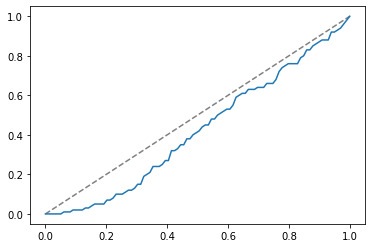

0.0

In [5]:
# Plot the cummulative p-value distribution
# If the bootstrap is good, it should be approximately uniform
# If below uniform, the bootstrap is conservative (invalid variance estimates?)
# If above uniform, the bootstrap is invalid (conservative variance estimates?)
plot_power(p_vals)

Try row sampling with replacement to get "bootstrap" matrices

In [6]:
# Bootstrap
A_row_jumble = row_sample_with_replacement(A_obs, B=B)

# Testing
p_vals = []
for i in range(B):
    A_row_jumble_sample = A_row_jumble[i, :, :]

    # Embed the observed and bootstrapped graphs
    Y_unf = UASE([A_obs, A_row_jumble_sample], d=d)

    # Compute the p-value
    p_val = test_temporal_displacement_two_times(Y_unf, n)
    p_vals.append(p_val)



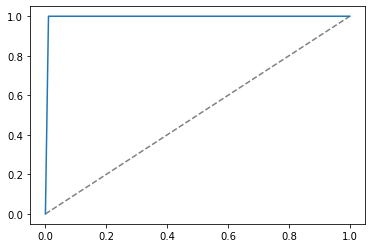

1.0

In [7]:
plot_power(p_vals)

In [8]:
plot_embedding(UASE([A_obs, A_row_jumble[0], A_row_jumble[1]], 2), n, 3, tau)

In [27]:
def edgelist_jackknife(A, B):
    """
    Pick a random entry and set it to zero
    """
    n = A.shape[0]
    A_star = np.zeros((B, n, n))

    for i in range(B):
        A_star[i] = A.copy()
        for j in range(3):
            idx = np.random.choice(n, size=2, replace=True)
            A_star[i][idx[0], idx[1]] = 0
            A_star[i][idx[1], idx[0]] = 0

    return A_star

# Bootstrap
A_jk = edgelist_jackknife(A_obs, B=B)

# Testing
p_vals = []
for i in range(B):
    A_jk_sample = A_jk[i, :, :]

    # Embed the observed and bootstrapped graphs
    Y_unf = UASE([A_obs, A_jk_sample], d=d)

    # Compute the p-value
    p_val = test_temporal_displacement_two_times(Y_unf, n)
    p_vals.append(p_val)


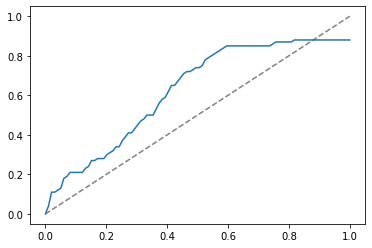

0.13

In [28]:
plot_power(p_vals)

In [29]:
plot_embedding(UASE([A_obs, A_jk[0], A_jk[1]], 2), n, 3, tau)

## 3 April 2024 - KNN stuff

In [2]:
# Run a k-NN on a K community SBM
# Do we run k-NN on an embedding or the adjacency matrix? - should try both 
# would proof on the adj. mat be easier to prove something about?

n = 2000
T = 1
d = 2

# Generate an SBM
# As, tau = make_iid(n, T, iid_prob=0.9)

K = 5
As, tau, _ = make_temporal_simple(n, T, K=K) # K community SBM
A_obs = As[0]

In [3]:
yhat = UASE(As, d=d, flat=False)

In [4]:
# plt.plot(yhat[0, :, 0], yhat[0, :, 1], 'o', c=tau/K)
yhat_plot = UASE(As, d=d, flat=True)
plot_embedding(yhat_plot, n, T, tau)

In [5]:
# run a k-NN on the embedding yhat
# n_neighbors = n//K
n_neighbors = 5

# Here we use Minkowski distance
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(yhat[0])
distances, indices = nbrs.kneighbors(yhat[0])

# # Here we use cosine distance
# # Note we need to use brute force for cosine distance
# from sklearn.neighbors import NearestNeighbors
# nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='brute', metric='cosine').fit(yhat[0])
# distances, indices = nbrs.kneighbors(yhat[0])


# what is k?
# what is n_neighbors?
# answer: k is the number of neighbors to consider, n_neighbors is the number of neighbors to return

In [6]:
indices

array([[   0,   32,  345,  301,  385],
       [   1,   48,  271,  334,   94],
       [   2,  208,   22,  164,  342],
       ...,
       [1997, 1879, 1769, 1600, 1695],
       [1998, 1677, 1646, 1644, 1822],
       [1999, 1823, 1965, 1713, 1707]])

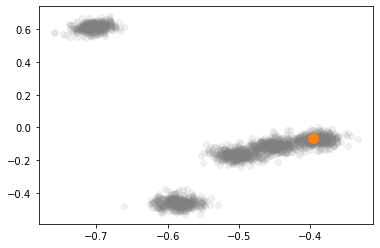

In [7]:
# plot whole embedding in the background
plt.plot(yhat[0, :, 0], yhat[0, :, 1], 'o', alpha=0.1, color='gray')
# plot the first embedding point and its neighbours
plt.plot(yhat[0, indices[0], 0], yhat[0, indices[0], 1], 'o')
plt.plot(yhat[0, 0, 0], yhat[0, 0, 1], markersize=10, marker='o')

In [8]:
import numba as nb

@nb.njit
def P_est_from_A_obs(n, A_obs):
    P_est = np.zeros((n, n))
    for i in range(n):
        idx = indices[i]
        A_i = (1/n_neighbors) * np.sum(A_obs[:, idx], axis=1)
        P_est[:, i] = A_i
    return P_est

# compile the function
P_est_fake = P_est_from_A_obs(1, np.zeros((1,1)))

In [9]:
P_est = P_est_from_A_obs(n, A_obs)

In [10]:
# P_est = np.zeros((n, n))
# for i in range(n):
#     idx = indices[i]
#     A_i = (1/n_neighbors) * np.sum(A_obs[:, idx], axis=1)
#     P_est[:, i] = A_i

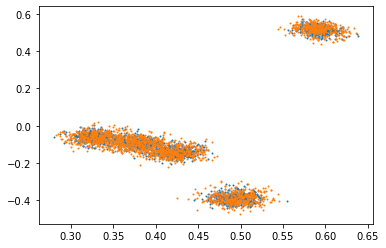

In [11]:
# # draw bernoulli trials from P_est
# A_est = np.zeros((n, n))
# for i in range(n):
#     for j in range(n):
#         A_est[i, j] = np.random.binomial(1, P_est[i, j])

A_est = make_inhomogeneous_rg(P_est)

yhat_est = UASE([A_obs,A_est], d=d, flat=False)

plt.plot(yhat_est[0, :, 0], yhat_est[0, :, 1], 'o', markersize=1)
plt.plot(yhat_est[1, :, 0], yhat_est[1, :, 1], 'o', markersize=1)

In [12]:
# TODO: we assume that KNN is deteministic???
B = 100
p_vals = []
for i in range(B):
    A_est = make_inhomogeneous_rg(P_est)

    yhat_est = UASE([A_obs,A_est], d=2)
    p_val = test_temporal_displacement_two_times(yhat_est, n)
    p_vals.append(p_val)

# yhat_est = UASE([A_obs,A_est], d=d, flat=False)

# plt.plot(yhat_est[0, :, 0], yhat_est[0, :, 1], 'o')
# plt.plot(yhat_est[1, :, 0], yhat_est[1, :, 1], 'o')

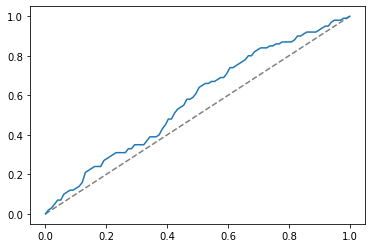

0.07

In [13]:
plot_power(p_vals)

Try k-NN on $A$ not $\hat{Y}$

In [14]:
# run a k-NN on the adjacency matrix
n_neighbors=3
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(A_obs)
distances, indices = nbrs.kneighbors(A_obs)

In [15]:
P_est = np.zeros((n, n))
for i in range(n):
    idx = indices[i]
    A_i = (1/n_neighbors) * np.sum(A_obs[:, idx], axis=1)
    P_est[:, i] = A_i

In [16]:
# TODO: we assume that KNN is deteministic???
B = 100
p_vals = []
for i in range(B):
    A_est = make_inhomogeneous_rg(P_est)

    yhat_est = UASE([A_obs,A_est], d=2)
    p_val = test_temporal_displacement_two_times(yhat_est, n)
    p_vals.append(p_val)



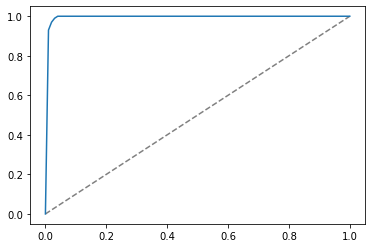

1.0

In [17]:
plot_power(p_vals)

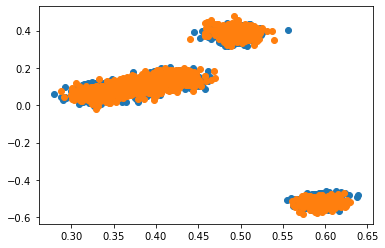

In [18]:
yhat_est = UASE([A_obs,A_est], d=d, flat=False)

plt.plot(yhat_est[0, :, 0], yhat_est[0, :, 1], 'o')
plt.plot(yhat_est[1, :, 0], yhat_est[1, :, 1], 'o')

Let's compare the kNN bootstrap with the parametric bootstrap to estimate the variance of each of $K$=2 clusters ( we will increase $K$ as we get good at coding)
We want to compare these with the truthm, and anticipate the better bootstrap will give a closer to the truth estimate of variance than the less good one

In [19]:
# Run a k-NN on a K=2 community SBM

n = 300
T = 1
d = 2

# Generate an SBM
# As, tau = make_iid(n, T, iid_prob=0.9)

K = 2
As, tau, _ = make_temporal_simple(n, T, K=K) # K community SBM
A_obs = As[0]

In [20]:
yhat = UASE(As, d=d, flat=False)

In [96]:
# run a k-NN on the embedding yhat
n_neighbors = 5

# Here we use Minkowski distance
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(yhat[0])
distances, indices = nbrs.kneighbors(yhat[0])

In [97]:
@nb.njit
def P_est_from_A_obs(n, A_obs):
    P_est = np.zeros((n, n))
    for i in range(n):
        idx = indices[i]
        A_i = (1/n_neighbors) * np.sum(A_obs[:, idx], axis=1)
        P_est[:, i] = A_i
    return P_est

# compile the function
P_est_fake = P_est_from_A_obs(1, np.zeros((1,1)))

In [98]:
P_est = P_est_from_A_obs(n, A_obs)

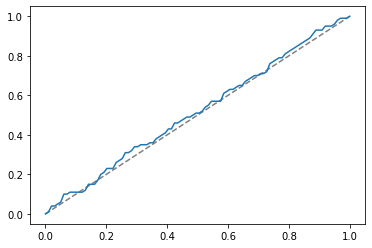

0.06

In [99]:
B = 100
p_vals = []
A_boots = []
for i in range(B):
    A_est = make_inhomogeneous_rg(P_est)

    yhat_est = UASE([A_obs,A_est], d=2)
    p_val = test_temporal_displacement_two_times(yhat_est, n)
    p_vals.append(p_val)
    A_boots.append(A_est)

#plot
plot_power(p_vals)

In [100]:
# # YUCK WE HATE THIS
# yhat_cov_ests = []

# # for each cluster, compute the covariance matrix, based on yhat obtained from A_obs
# # we assume this is the "true" cluster variance
# for clust in range(K):
#     yhat_obs_clust = yhat_obs[tau == clust]
#     cov_obs = np.cov(yhat_obs_clust, rowvar=False)
#     yhat_cov_ests.append(cov_obs)

# yhat_cov_ests_n = [yhat_cov_ests[comm] for comm in tau]
# assert len(yhat_cov_ests_n) == n

In [101]:
# Draw M samples from the same P matrix
A_redraws = []
# this means that there are the same number of bootstraps as there are draws total from P
M = B-1
for m in range(M):
    As, tau, _ = make_temporal_simple(n, T, K=K) # K community SBM
    # NEED TO MAKE SURE THE FUNCTION ABOVE DOESN'T JUMBLE THE TAUS LEAVE THEM IN ORDER FOR CHRIST'S SAKE
    A_redraws.append(As[0])

In [102]:
A_redraws_unfolded = np.column_stack(A_redraws)
assert A_redraws_unfolded.shape == (n, n*M)

In [103]:
# put A_obs and A_redraws with A_boots
A_concat = A_boots.copy()
A_concat.append(A_obs) # [A_boots, A_obs]
A_concat.extend(A_redraws) # [A_boots, A_obs, A_redraws]

yhat_concat = UASE(A_concat, d=d, flat=False)
yhat_boots = yhat_concat[:-B]
yhat_obs = yhat_concat[B:] # this is the obs and the redraws

assert len(A_concat) == 2*B

# store the n covariance matrix estimates from the bootstraps
cov_ests_boots = []
for i in range(n):
    # these are the B emebeddings of node i
    pts_node_i = yhat_boots[:, i, :]
    cov_node_i = np.cov(pts_node_i, rowvar=False) # d x d matrix
    # print(cov_node_i.shape)
    # print(cov_node_i)
    cov_ests_boots.append(cov_node_i)

# store the n covariance matrix estimates from the obs and redraws
cov_ests_obs = []
for i in range(n):
    # these are the B emebeddings of node i
    pts_node_i = yhat_obs[:, i, :]
    cov_node_i = np.cov(pts_node_i, rowvar=False) # d x d matrix
    # print(cov_node_i.shape)
    # print(cov_node_i)
    cov_ests_obs.append(cov_node_i)

need to figure out how to compare variance estimates in the d x d case

In [104]:
# compute mse between the two sets of covariance estimates for each node
mse = []
for i in range(n):
    mse_i = np.linalg.norm(cov_ests_boots[i] - cov_ests_obs[i])
    mse.append(mse_i)

Average MSE:  9.089144412995399e-05


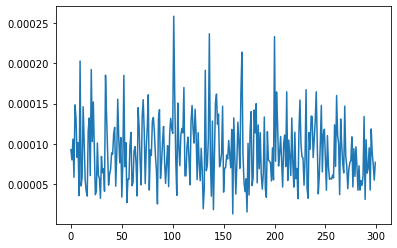

In [105]:
plt.plot(mse)
print("Average MSE: ", np.mean(mse))

Ed would like to try a dirichlet mixed model